In [20]:
import os
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import sampler
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

In [37]:
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data Transformations for VGG-16

### Training Set Transformations
1. **Resize** the image 
2. **Randomly crop** 
3. **Random horizontal flip** with a probability of 50%.
4. **Random RGB color shift**, including:
   - Brightness adjustment
   - Contrast variation
   - Saturation change
   - Hue shift
5. **Convert** the image to a tensor.
6. **Normalize** pixel values to have a mean of **(0.5, 0.5, 0.5)** and a standard deviation of **(0.5, 0.5, 0.5)**.

---

### Test/Validation Set Transformations
1. **Resize** the image
2. **Center crop** 
3. **Convert** the image to a tensor.
4. **Normalize** using the same mean and standard deviation as used for training.



In [38]:
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((72, 72)),  
        transforms.RandomCrop((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((72, 72)), 
        transforms.CenterCrop((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


In [39]:
train_dataset=datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transforms)
test_dataset=datasets.CIFAR10(root='./data',train=False,download=True,transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
validation_fraction=0.1
validation_num=int(validation_fraction * len(train_dataset))
train_indices = torch.arange(0, len(train_dataset) - validation_num)
valid_indices = torch.arange(len(train_dataset) - validation_num, len(train_dataset))

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [41]:
valid_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=valid_sampler,
                          num_workers=2,
                          pin_memory=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          sampler=train_sampler,
                          num_workers=2,
                          pin_memory=True
                          )

test_loader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                              num_workers=2,
                            pin_memory=True)

In [42]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([64, 3, 64, 64])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([2, 1, 6, 9, 8, 0, 3, 2, 5, 4])


## Architecture

- The network takes **224 × 224 RGB images** as input.


### Convolutional Layers
- Uses **3×3 convolution filters** throughout the network.
- **Stride** for all convolutions is **1 pixel**.
- Padding is 1 pixel.

### Pooling Layers
- **Max-pooling** is used after some (not all) convolution layers.
- Pooling is done over a **2×2 window** with a **stride of 2**.
- There are **five max-pooling layers** in total.

### Fully Connected Layers
- The convolutional layers are followed by **three fully connected layers**:
  1. First FC layer: 4096 units
  2. Second FC layer: 4096 units
  3. Third FC layer: 1000 units (for classification into 1000 classes)
- Final classification is done via a **softmax** layer.

### Activation and Normalization
- All hidden layers use the **ReLU activation function**.

##  VGG Training Procedure

- Training uses **mini-batch gradient descent** with **backpropagation**.
- Optimizer includes **momentum**, set to **0.9**, to help accelerate learning.
- **Batch size** is **256** images per training step.
- Uses **cross-entropy loss** (multinomial logistic regression) for classification.
- Applies **weight decay** (L2 regularization) with a factor of **5e-4** to prevent overfitting.
- **Dropout** is used in the first two fully-connected (dense) layers


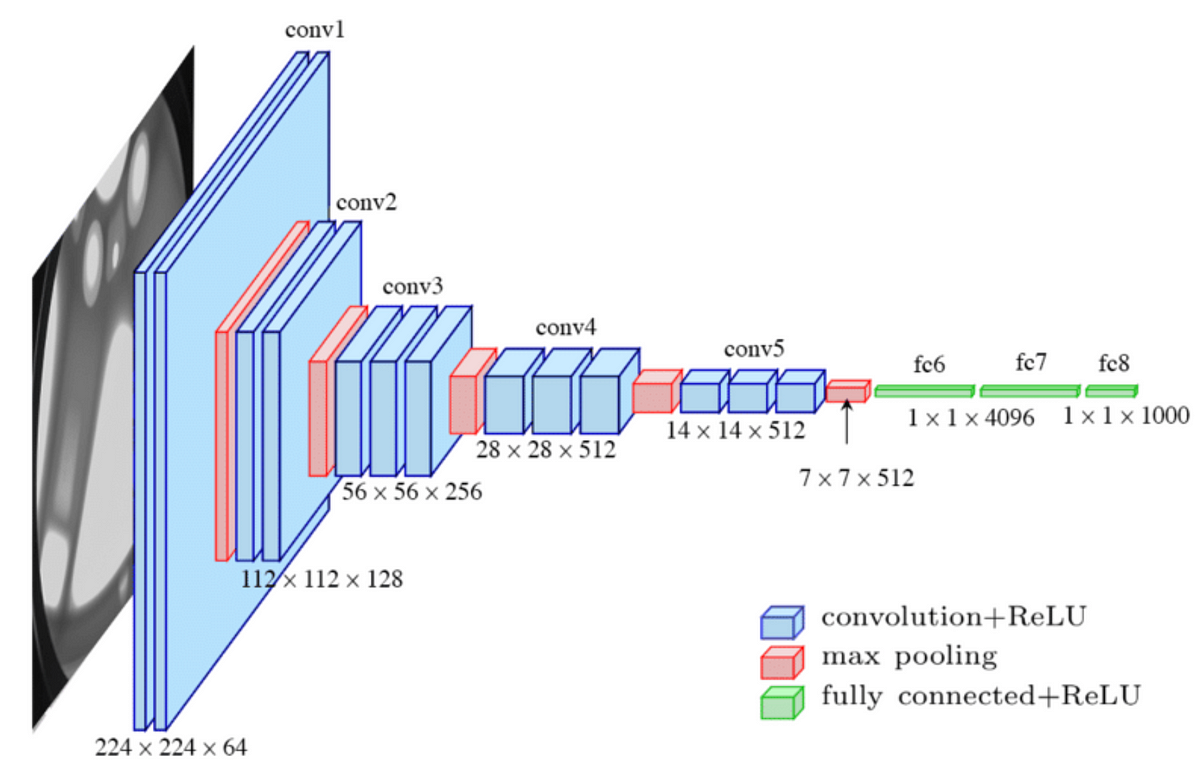

In [43]:
from torch.nn import Conv2d,ReLU,MaxPool2d,Dropout,Linear

In [49]:
class VGG16(torch.nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.num_classes=num_classes
    self.feature_extractor=torch.nn.Sequential(
        Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,stride=1),
        ReLU(),
        MaxPool2d(kernel_size=2,stride=2),
        Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=1),
        ReLU(),
        MaxPool2d(kernel_size=2,stride=2),
        Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=1),
        ReLU(),
        MaxPool2d(kernel_size=2,stride=2),
        Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        ReLU(),
        MaxPool2d(kernel_size=2,stride=2),
        Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        ReLU(),
        Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1,stride=1),
        ReLU(),
        MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier=torch.nn.Sequential(
        Linear(in_features=512*2*2,out_features=4096),
        ReLU(),
        Dropout(),
        Linear(in_features=4096,out_features=4096),
        ReLU(),
        Dropout(),
        Linear(in_features=4096,out_features=num_classes)
    )
    self.apply(self._init_weights)
      
  def _init_weights(self, m):
      if isinstance(m, (Conv2d, Linear)):
          torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
          if m.bias is not None:
              torch.nn.init.constant_(m.bias, 0)

  def forward(self,X):
    X=self.feature_extractor(X)
    X=torch.flatten(X,1)
    logits=self.classifier(X)
    return logits

  def compute_accuracy(self,data_loader,device):
    correct_preds=0
    total_preds=0

    for batch_idx,(images,labels) in enumerate(data_loader):
      images=images.to(device)
      labels=labels.to(device)
      logits=self.forward(images)
      probs=F.softmax(logits,dim=1)
      preds=torch.argmax(probs,dim=1)
      correct_preds+=torch.sum(preds==labels)
      total_preds+=labels.size(0)

    accuracy=correct_preds/total_preds
    return accuracy*100

  def train_model(self,num_epochs,train_loader,valid_loader,test_loader,device):
    logging_interval=100
    torch.random.manual_seed(RANDOM_SEED)
    self.to(device)
    self.optimizer=torch.optim.SGD(self.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)
    self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):
      self.train()

      for batch_idx,(images,labels) in enumerate(train_loader):
        images=images.to(device)
        labels=labels.to(device)
        logits=self.forward(images)
        loss=F.cross_entropy(logits,labels)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        minibatch_loss_list.append(loss.item())

        if (batch_idx+1) % logging_interval==0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

      self.eval()
      with torch.no_grad():
        train_acc=self.compute_accuracy(train_loader,device)
        valid_acc=self.compute_accuracy(valid_loader,device)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {valid_acc:.2f}%")

        self.scheduler.step(valid_acc_list[-1])

    test_acc = self.compute_accuracy(test_loader, device=device)
    print(f"Test Accuracy: {test_acc:.2f}%")

    return minibatch_loss_list, train_acc_list, valid_acc_list


In [50]:
vgg=VGG16(num_classes=10)
minibatch_loss_list, train_acc_list, valid_acc_list=vgg.train_model(num_epochs=NUM_EPOCHS,train_loader=train_loader,valid_loader=valid_loader,test_loader=test_loader,device=DEVICE)

Epoch: 1/50, Batch: 100/703, Loss: 2.2176
Epoch: 1/50, Batch: 200/703, Loss: 2.0813
Epoch: 1/50, Batch: 300/703, Loss: 1.8954
Epoch: 1/50, Batch: 400/703, Loss: 2.0119
Epoch: 1/50, Batch: 500/703, Loss: 1.9738
Epoch: 1/50, Batch: 600/703, Loss: 1.7432
Epoch: 1/50, Batch: 700/703, Loss: 1.6729
Epoch: 1/50, Train Accuracy: 34.62%, Validation Accuracy: 34.14%
Epoch: 2/50, Batch: 100/703, Loss: 1.6003
Epoch: 2/50, Batch: 200/703, Loss: 1.7000
Epoch: 2/50, Batch: 300/703, Loss: 1.4897
Epoch: 2/50, Batch: 400/703, Loss: 1.5488
Epoch: 2/50, Batch: 500/703, Loss: 1.5492
Epoch: 2/50, Batch: 600/703, Loss: 1.4726
Epoch: 2/50, Batch: 700/703, Loss: 1.4546
Epoch: 2/50, Train Accuracy: 51.57%, Validation Accuracy: 51.64%
Epoch: 3/50, Batch: 100/703, Loss: 1.2787
Epoch: 3/50, Batch: 200/703, Loss: 1.3365
Epoch: 3/50, Batch: 300/703, Loss: 1.2974
Epoch: 3/50, Batch: 400/703, Loss: 1.1175
Epoch: 3/50, Batch: 500/703, Loss: 1.0758
Epoch: 3/50, Batch: 600/703, Loss: 1.1507
Epoch: 3/50, Batch: 700/703, L

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):
    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    ax1.plot(range(len(minibatch_loss_list)),
             minibatch_loss_list, label='Minibatch Loss', color='blue')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([0, np.max(minibatch_loss_list[1000:])*1.5])
    
    running_avg = np.convolve(minibatch_loss_list,
                              np.ones(averaging_iterations,) / averaging_iterations,
                              mode='valid')
    ax1.plot(range(len(running_avg)),
             running_avg, label=f'Running Average (avg {averaging_iterations} iterations)', color='orange')

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.legend()


    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs + 1))
    newpos = [e * iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    

    plt.tight_layout()


    plt.show()



<Figure size 1200x400 with 0 Axes>

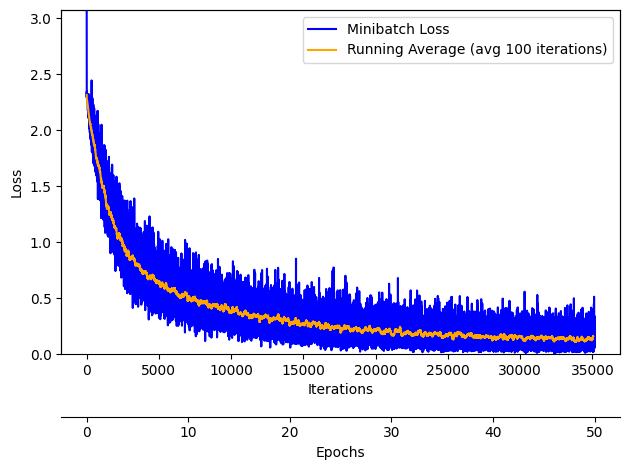

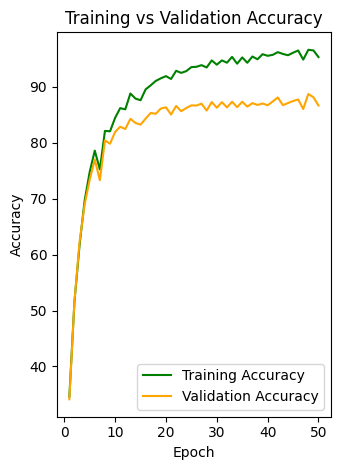

In [55]:
import matplotlib.pyplot as plt

train_acc_list = [x.cpu().item() if hasattr(x, 'cpu') else x for x in train_acc_list]
valid_acc_list = [x.cpu().item() if hasattr(x, 'cpu') else x for x in valid_acc_list]

epochs = range(1, NUM_EPOCHS+1)

plt.figure(figsize=(12, 4))

plot_training_loss(minibatch_loss_list, num_epochs=NUM_EPOCHS, iter_per_epoch=len(train_loader))


plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Training Accuracy', color='green')
plt.plot(epochs, valid_acc_list, label='Validation Accuracy', color='orange')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()